# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Order matters, do not change it.
!pip install tensorflow-object-detection-api
!pip uninstall tensorflow
!pip install tensorflow==1.15
import tensorflow as tf


     |████████████████████████████████| 583kB 6.6MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 3.2MB 11.3MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-cp37-none-any.whl size=844515 sha256=7936c563db3c17edcb249706d150effb7ccd3fa3b4cd37f9d38ded240bd52208
  Stored in directory: /root/.cache/pip/wheels/4a/54/d0/cfca11930c4b2025d40dede77059094070a67cc3e7bd3b285f
Successfully built tensorflow-object-detection-api
Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/py

In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile

from PIL import Image
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [ ]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [ ]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [ ]:
# What model to download.
MODEL_NAME = 'inference_graph'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'labelmap.pbtxt')

In [ ]:
PATH_TO_FROZEN_GRAPH='drive/MyDrive/Source Codes/SSD/inference_graph/frozen_inference_graph.pb'
PATH_TO_LABELS='drive/MyDrive/Source Codes/SSD/inference_graph/labelmap.pbtxt'

## Load a (frozen) Tensorflow model into memory.

In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.compat.v1.GraphDef()
  with tf.compat.v1.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Face Mask Images Detection

In [ ]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/drive/MyDrive/Source Codes/Images/with_mask'
TEST_IMAGE_PATHS1 = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'mask ({}).jpg'.format(i)) for i in range(1, 1761) ]

PATH_TO_TEST_IMAGES_DIR = '/content/drive/MyDrive/SSD/Source Codes/Images/without_mask'
TEST_IMAGE_PATHS2 = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'without mask ({}).jpg'.format(i)) for i in range(1, 1794) ]

TEST_IMAGE_PATHS = TEST_IMAGE_PATHS1 + TEST_IMAGE_PATHS2

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [ ]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [ ]:
# FUNCTION TO GET ACCURACY
def return_coordinates(
    image,
    boxes,
    classes,
    scores,
    category_index,
    instance_masks=None,
    instance_boundaries=None,
    keypoints=None,
    use_normalized_coordinates=False,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=4,
    groundtruth_box_visualization_color='black',
    skip_scores=False,
    skip_labels=False):
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_instance_boundaries_map = {}
  box_to_score_map = {}
  box_to_keypoints_map = collections.defaultdict(list)
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if instance_boundaries is not None:
        box_to_instance_boundaries_map[box] = instance_boundaries[i]
      if keypoints is not None:
        box_to_keypoints_map[box].extend(keypoints[i])
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      else:
        display_str = ''
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in category_index.keys():
              class_name = category_index[classes[i]]['name']
            else:
              class_name = 'N/A'
            display_str = str(class_name)
        if not skip_scores:
          if not display_str:
            display_str = '{}%'.format(int(100*scores[i]))
          else:
            display_str = '{}: {}%'.format(display_str, int(100*scores[i]))
        box_to_display_str_map[box].append(display_str)
        box_to_score_map[box] = scores[i]
        if agnostic_mode:
          box_to_color_map[box] = 'DarkOrange'
        else:
          box_to_color_map[box] = 'Blue'

  # Draw all boxes onto image.
  coordinates_list = []
  counter_for = 0
  for box, color in box_to_color_map.items():
    ymin, xmin, ymax, xmax = box
    height, width, channels = image.shape
    ymin = int(ymin*height)
    ymax = int(ymax*height)
    xmin = int(xmin*width)
    xmax = int(xmax*width)
    coordinates_list.append([ymin, ymax, xmin, xmax, (box_to_score_map[box]*100)])
    counter_for = counter_for + 1

  return coordinates_list

In [ ]:
import collections

accuracy_list = []

for image_path in TEST_IMAGE_PATHS:
  try:

    image = Image.open(image_path)
    print(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    
    coordinates = return_coordinates(
                          image_np,
                          (output_dict['detection_boxes']),
                          (output_dict['detection_classes']).astype(np.int32),
                          (output_dict['detection_scores']),
                          category_index,
                          instance_masks=output_dict.get('detection_masks'),
                          use_normalized_coordinates=True,
                          line_thickness=10,
                          min_score_thresh=0.5)
      
    for i in range(len(coordinates)):
      accuracy = coordinates[i][4]
      accuracy_list.append(accuracy)
      print(accuracy)

    # plt.figure(figsize=IMAGE_SIZE)
    # plt.imshow(image_np)
  except (OSError, ValueError):
    continue 

Streaming output truncated to the last 5000 lines.
98.24995994567871
/content/drive/MyDrive/SSD/imagesss/Images/with_mask/mask (1040).jpg
97.81330823898315
/content/drive/MyDrive/SSD/imagesss/Images/with_mask/mask (1041).jpg
64.23484086990356
51.58184766769409
/content/drive/MyDrive/SSD/imagesss/Images/with_mask/mask (1042).jpg
96.81652784347534
/content/drive/MyDrive/SSD/imagesss/Images/with_mask/mask (1043).jpg
50.29016137123108
/content/drive/MyDrive/SSD/imagesss/Images/with_mask/mask (1044).jpg
97.94625639915466
/content/drive/MyDrive/SSD/imagesss/Images/with_mask/mask (1045).jpg
99.73310232162476
/content/drive/MyDrive/SSD/imagesss/Images/with_mask/mask (1046).jpg
96.38644456863403
/content/drive/MyDrive/SSD/imagesss/Images/with_mask/mask (1047).jpg
95.22053003311157
/content/drive/MyDrive/SSD/imagesss/Images/with_mask/mask (1048).jpg
71.49004936218262
58.60195755958557
/content/drive/MyDrive/SSD/imagesss/Images/with_mask/mask (1049).jpg
71.49004936218262
58.60195755958557
/conten

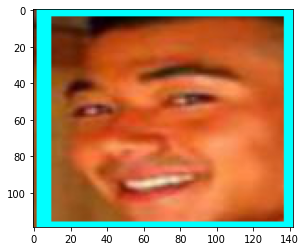

In [ ]:
%matplotlib inline
plt.imshow(image_np)

In [ ]:
import statistics
print("Number of successful files with accuracy:")
print(len(accuracy_list))
print("Mean of accuracy:")
print(statistics.mean(accuracy_list))


Number of successful files with accuracy:
3696
Mean of accuracy:
90.50266412106943


# Face Mask Real-Time Detection

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

# start streaming video from webcam
# must comment this out for the bottom one to work

# video_stream() ##UNCOMMENT FOR  A SURPRISE HEHE!!

# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
with tf.Session(graph=detection_graph) as sess:
  while True:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      # convert JS response to OpenCV Image
      img = js_to_image(js_reply["img"]) # when video detects a face

      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(img, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run([boxes, scores, classes, num_detections],feed_dict={image_tensor: image_np_expanded})

      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          img,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)

      cv2_imshow(cv2.resize(img, (800,600)))
      if cv2.waitKey(25) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

MessageError: ignored